<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-1-Build/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [X] Plot a confusion matrix for your Tanzania Waterpumps model.
- [X] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [X] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [X] Commit your notebook to your fork of the GitHub repo.
- [X] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [X] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [X] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install -U --quiet category_encoders pandas-profiling

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline

random_state = 13

# Assignment

### **wrangle**

In [0]:
# impute the median latitude, longitude, and gps_height from other geographical features
# working through the features from most to least specific until there are no nan's or 
# no more geographical features to check
# must set impute_source to the source dataframe before calling
# this function is meant to be used as the target of a DataFrame.apply(impute_gps, axis=1) call
#   to be used on a subset of the dataframe where latitude and longitude are nan's
# parameter 'row' = a pandas series. a single row from a dataframe
impute_source = None

def impute_gps(row):
  assert impute_source is not None, 'impute_source not set'
  geo_features = ['basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward']
  geo_features_most_to_least_specific = impute_source[geo_features].nunique().sort_values(ascending=False).index.tolist()
  for geo in geo_features_most_to_least_specific:
    if row[geo] == '':
      continue
    # only calculate if it is nan
    if np.isnan(row['latitude']):
      row['latitude'] = impute_source[impute_source[geo] == row[geo]]['latitude'].median()
    if np.isnan(row['longitude']):
      row['longitude'] = impute_source[impute_source[geo] == row[geo]]['longitude'].median()
    if np.isnan(row['gps_height']):
      row['gps_height'] = impute_source[impute_source[geo] == row[geo]]['gps_height'].median()
    # if none of the values are nans, stop looking
    if not (np.isnan(row['latitude']) and np.isnan(row['longitude']) and np.isnan(row['gps_height'])):
      break
  
  # return only what we changed
  return row[['gps_height', 'longitude', 'latitude']]

In [0]:
def wrangle(dataframe):
  df = dataframe.copy()

  # high cardinality categoricals cleanup
  # tag missing values
  # fill nan's with empty strings
  # convert to lower case and remove all non-alphanumeric characters to group
  #   things that look alike into 1 thing
  hcc_to_clean = ['funder', 'installer', 'subvillage', 'ward', 'scheme_name']
  for column in hcc_to_clean:
    df[column] = df[column].fillna('').str.lower().str.replace('[^a-z0-9]', '')
  #   df[column + '_MISSING'] = (df[column] == '') | (df[column].str.match('^(un|not)known$'))

  # # drop created 'ward_MISSING' because there are none missing
  # assert df['ward_MISSING'].sum() == 0, 'some nulls in ward'
  # df.drop(columns='ward_MISSING', inplace=True)
  
  # also combine items in those same features more explicitly
  df['funder'] = df['funder'].str.replace('^quickwin$', 'quickwins')
  df['installer'] = df['installer'].str.replace('^notknown$', '')
  df['installer'] = df['installer'].str.replace('^adra.+', 'adra')
  df['installer'] = df['installer'].str.replace('^af$', 'africa')
  df['installer'] = df['installer'].str.replace('^anglican.+', 'anglican')
  df['installer'] = df['installer'].str.replace('^ch$', 'china')
  df['installer'] = df['installer'].str.replace('^gover$', 'government')
  df['installer'] = df['installer'].str.replace('^governme$', 'government')
  df['installer'] = df['installer'].str.replace('^in$', 'individuals')
  df['installer'] = df['installer'].str.replace('^individual$', 'individuals')
  df['installer'] = df['installer'].str.replace('^lions$', 'lionsclub')
  df['installer'] = df['installer'].str.replace('^(local|localltechnician|localtechnicaltec|localtechnitian)$', 'localtechnician')
  df['installer'] = df['installer'].str.replace('^maswi.+', 'maswi')
  df['installer'] = df['installer'].str.replace('^adra.+', 'adra')
  df['installer'] = df['installer'].str.replace('^quick$', 'quickwin')
  df['installer'] = df['installer'].str.replace('^rc.*', 'rcchurch')
  df['installer'] = df['installer'].str.replace('^roman.+', 'romancatholic')
  df['installer'] = df['installer'].str.replace('^rwe.+', 'rwe')
  df['installer'] = df['installer'].str.replace('^schoo$', 'school')
  df['installer'] = df['installer'].str.replace('^tanzania.+', 'tanzaniagovernment')
  df['installer'] = df['installer'].str.replace('^tasaf.+', 'tasaf')
  df['installer'] = df['installer'].str.replace('^unknown', '')
  df['installer'] = df['installer'].str.replace('^villag.+', 'village')
  df['installer'] = df['installer'].str.replace('^water.+', 'water')

  # boolean feature cleanup
  # tag missing values
  # convert to floats to keep the nan's for imputing
  boolean_features = ['public_meeting', 'permit']
  for column in boolean_features:
#    df[column + '_MISSING'] = df[column].isnull()
    df[column] = df[column].astype(float)

  # impute missing latitude, longitude, gps_height
  # missing is defined as longitude = 0, latitude = -2e-08
  # gps_height is assumed missing for observations where the above are true
  #   (exploration has shown that gps_height = 0 for all observations that meet those conditions)
  # first, we convert these values to nans, then impute the values for each feature
  # the imputed values are the median of that feature for all observations in the dataframe that
  #   match that observation's other geographical information
  df['longitude'] = df['longitude'].replace(0, np.nan)
  df['latitude'] = df['latitude'].replace(-2e-08, np.nan)
  df.loc[df['longitude'].isnull(), 'gps_height'] = np.nan
#  df['lat_long_MISSING'] = (df['longitude'].isnull()) | (df['latitude'].isnull())
  lat_long_MISSING = (df['longitude'].isnull()) | (df['latitude'].isnull())
  imputed_gps = df[lat_long_MISSING].apply(impute_gps, axis=1)
  df.update(imputed_gps, overwrite=False)     # overwrite=False means it will only overwrite nan values
  assert not df['longitude'].isnull().any(), 'null longitude'
  assert not df['latitude'].isnull().any(), 'null latitude'

  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  # Also create a "missing indicator" column, because the fact that
  # values are missing may be a predictive signal.
  cols_with_zeros = ['construction_year', 'gps_height', 'population']
  for col in cols_with_zeros:
      df[col] = df[col].replace(0, np.nan)
#      df[col+'_MISSING'] = df[col].isnull()

  # Drop duplicate columns
  # including some features that are close duplicates - re-encoding of the same values
  # drop really high cardinality columns
  duplicates = ['quantity_group', 'payment_type', 'waterpoint_type_group']
  high_cardinality = ['wpt_name', 'subvillage', 'scheme_name']
  df = df.drop(columns=duplicates + high_cardinality)

  # Drop recorded_by (never varies) and id (always varies, random)
  unusable_variance = ['recorded_by', 'id']
  df = df.drop(columns=unusable_variance)

  # Convert date_recorded to datetime
  df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)

  # Extract components from date_recorded, then drop the original column
  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day
  df = df.drop(columns='date_recorded')

  # Engineer feature: how many years from construction_year to date_recorded
  df['years'] = df['year_recorded'] - df['construction_year']
  # df['years_MISSING'] = df['years'].isnull()

  return df

In [8]:
from sklearn.model_selection import train_test_split

train_split, val = train_test_split(train)

impute_source = train_split
df_train = wrangle(train_split)

impute_source = val
df_val = wrangle(val)

impute_source = test
df_test = wrangle(test)

df_train.shape, df_val.shape, df_test.shape

((44550, 36), (14850, 36), (14358, 35))

### assign X features matrix and y target vector

In [9]:
target = 'status_group'

cardinality = df_train.drop(columns=target).select_dtypes(exclude=['number', 'bool']).nunique()
low_cardinality = cardinality[cardinality<=50].index.tolist()

features = df_train.columns.drop(target)

X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

y_train = df_train[target]
y_val = df_val[target]

X_train.shape, X_val.shape, X_test.shape

((44550, 35), (14850, 35), (14358, 35))

### fit model

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_cardinality, use_cat_names=True),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=random_state, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_val, y_val)

print(f'Validation accuracy score: {score*100:.2f}%')

Validation accuracy score: 80.49%


## Plot a confusion matrix for your Tanzania Waterpumps model.

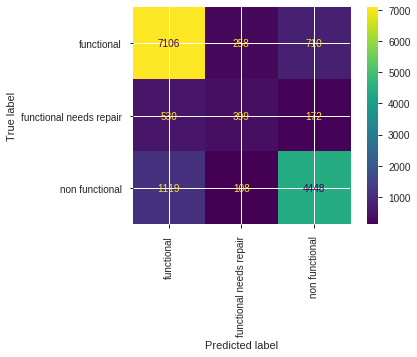

In [18]:
from sklearn.metrics import plot_confusion_matrix

cm = plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation='vertical', values_format='.0f')
cm;

## Continue to participate in our Kaggle challenge. 

Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).

## Submit your final predictions to our Kaggle competition.

Optionally, go to My Submissions, and "you may select up to 1 submission to be used to count towards your final leaderboard score."

In [19]:
impute_source = train
df_train_not_split = wrangle(train)

X_train_not_split = df_train_not_split[features]
y_train_not_split = df_train_not_split[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_cardinality, use_cat_names=True),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=random_state, n_jobs=-1)
)

pipeline.fit(X_train_not_split, y_train_not_split)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'scheme_management',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'water_quality', 'quality_group',
                                     'quantity', 'source', 'source_type',
                                     'source_class', 'waterpoint_type'],
                               drop_invariant=False, handle_missing='val...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        m

In [20]:
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission[target] = y_pred

filename = 'jcs-kaggle-waterpumps-submission-05.csv'

submission.to_csv(filename, index=False)

submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [0]:
from google.colab import files
files.download(filename)

## *RandomizedSearchCV / GridSearchCV, for model selection.*

 (See module 3 assignment notebook)

In [29]:
pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_cardinality, use_cat_names=True),
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__n_estimators' : [50, 100],
    'randomforestclassifier__criterion' : ['gini', 'entropy'],
    'randomforestclassifier__max_depth' : [None, 50, 100, 150],
    'randomforestclassifier__min_samples_split' : [2, 10],
    'randomforestclassifier__min_samples_leaf' : [1, 5, 10],
    'randomforestclassifier__max_features' : ['auto', None],
    'randomforestclassifier__bootstrap' : [True, False],
    'randomforestclassifier__warm_start' : [False, True],
}

search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions, n_iter=60, cv=4, verbose=10, n_jobs=-1, random_state=random_state)

search.fit(X_train_not_split, y_train_not_split)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   33.5s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 

RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=['basin',
                                                                  'region',
                                                                  'scheme_management',
                                                                  'extraction_type',
                                                                  'extraction_type_group',
                                                                  'extraction_type_class',
                                                                  'management',
                                                                  'management_group',
                                                                  'payment',
                                                                  'water_quality',
             

In [30]:
print(f'Best score: {search.best_score_ * 100:.2f}%')
print(f'Best parameters: {search.best_params_}')

Best score: 81.15%
Best parameters: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__warm_start': False, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__bootstrap': True}


In [31]:
y_pred = search.predict(X_test)

submission = sample_submission.copy()
submission[target] = y_pred

filename = 'jcs-kaggle-waterpumps-submission-06.csv'

submission.to_csv(filename, index=False)

submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [0]:
from google.colab import files
files.download(filename)

## *Stacking Ensemble*

this first 'ultimate-ensemble' got the highest score on the public leaderboards

In [37]:
# Filenames of your submissions you want to ensemble
files = ['jcs-kaggle-waterpumps-submission-01.csv', 'jcs-kaggle-waterpumps-submission-02.csv', 
         'jcs-kaggle-waterpumps-submission-03.csv', 'jcs-kaggle-waterpumps-submission-04.csv',
         'jcs-kaggle-waterpumps-submission-05.csv', 'jcs-kaggle-waterpumps-submission-06.csv',
         'rfecv.csv', 'selectkbest.csv', 'lecture_predictions.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]
 
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [0]:
from google.colab import files
files.download('my-ultimate-ensemble-submission.csv')

In [0]:
prev_submission = submission.copy()

In [41]:
# Filenames of your submissions you want to ensemble
filez = ['jcs-kaggle-waterpumps-submission-02.csv', 
         'jcs-kaggle-waterpumps-submission-03.csv', 'jcs-kaggle-waterpumps-submission-04.csv',
         'jcs-kaggle-waterpumps-submission-05.csv', 'jcs-kaggle-waterpumps-submission-06.csv',
         'selectkbest.csv', 'lecture_predictions.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in filez)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-cherry-picked-ensemble-submission.csv', index=False)
submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [46]:
submission[prev_submission['status_group'] != submission['status_group']]

,id,status_group
6,24806,non functional
38,72562,functional
198,73667,functional
211,29927,non functional
252,56540,functional
...,...,...
13648,27026,non functional
13696,69180,functional
13815,7444,functional
13883,51555,functional


In [0]:
files.download('my-cherry-picked-ensemble-submission.csv')

In [58]:
# Filenames of your submissions you want to ensemble
filez = ['jcs-kaggle-waterpumps-submission-02.csv', 'my-ultimate-ensemble-submission.csv',
         'jcs-kaggle-waterpumps-submission-03.csv', 'jcs-kaggle-waterpumps-submission-04.csv',
         'jcs-kaggle-waterpumps-submission-05.csv', 'jcs-kaggle-waterpumps-submission-06.csv',
         'selectkbest.csv', 'lecture_predictions.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in filez)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-super-stacked-ensemble-submission.csv', index=False)
submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [59]:
submission[prev_submission['status_group'] != submission['status_group']]

,id,status_group
38,72562,functional
198,73667,functional
338,63137,functional
474,72932,functional
605,11908,functional
...,...,...
13051,47480,functional
13696,69180,functional
13815,7444,functional
13883,51555,functional


In [0]:
files.download('my-super-stacked-ensemble-submission.csv')